In [2]:
%matplotlib inline

import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

from qiime.parse import parse_mapping_file
from qiime.format import format_mapping_file
from skbio.io.util import open_file
from scipy.stats import pearsonr, spearmanr
from biom import load_table

from IPython.display import Image

def load_mf(fn):
    with open_file(fn, 'U') as f:
        mapping_data, header, _ = parse_mapping_file(f)
        _mapping_file = pd.DataFrame(mapping_data, columns=header)
        _mapping_file.set_index('SampleID', inplace=True)
    return _mapping_file

def write_mf(f, _df):
    with open_file(f, 'w') as fp:
        lines = format_mapping_file(['SampleID'] + _df.columns.tolist(),
                                    list(_df.itertuples()))
        fp.write(lines+'\n')

In [3]:
def exploding_panda(_bt):
    """BIOM->Pandas dataframe converter

    Parameters
    ----------
    _bt : biom.Table
        BIOM table

    Returns
    -------
    pandas.DataFrame
        The BIOM table converted into a DataFrame
        object.
        
    References
    ----------
    Based on this answer on SO:
    http://stackoverflow.com/a/17819427/379593
    """
    m = _bt.matrix_data
    data = [pd.SparseSeries(m[i].toarray().ravel()) for i in np.arange(m.shape[0])]
    out = pd.SparseDataFrame(data, index=_bt.ids('observation'),
                             columns=_bt.ids('sample'))
    
    return out.to_dense()

/Users/yoshikivazquezbaeza/.virtualenvs/qiime-191/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


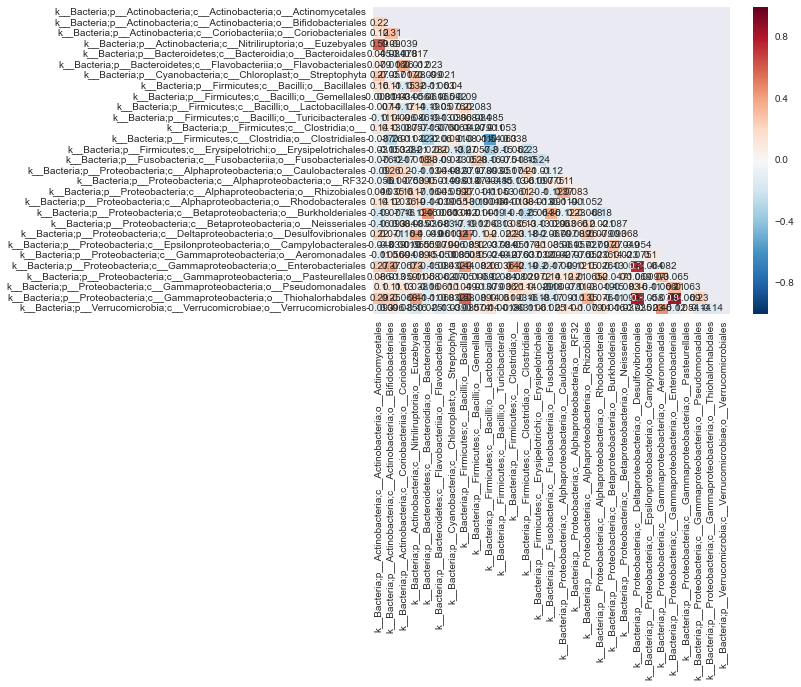

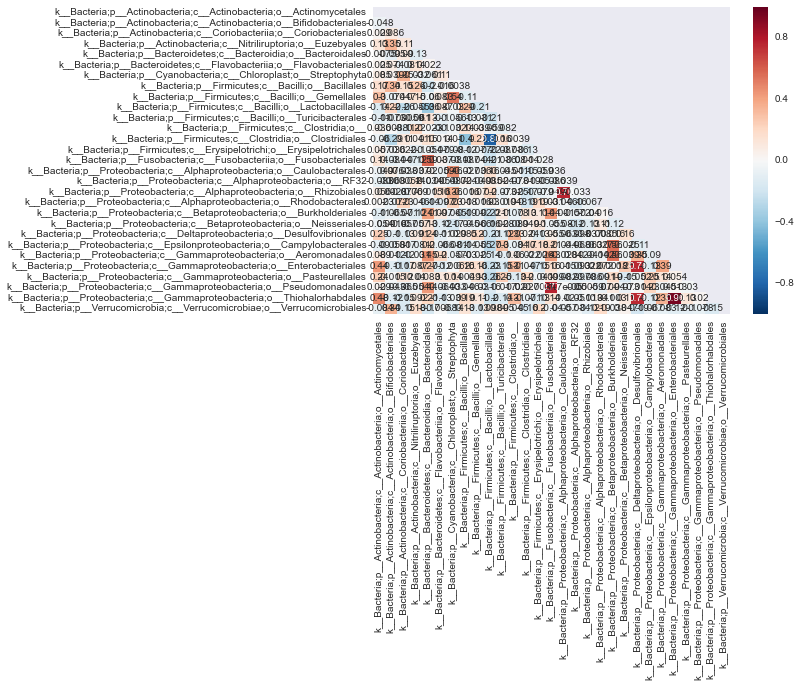

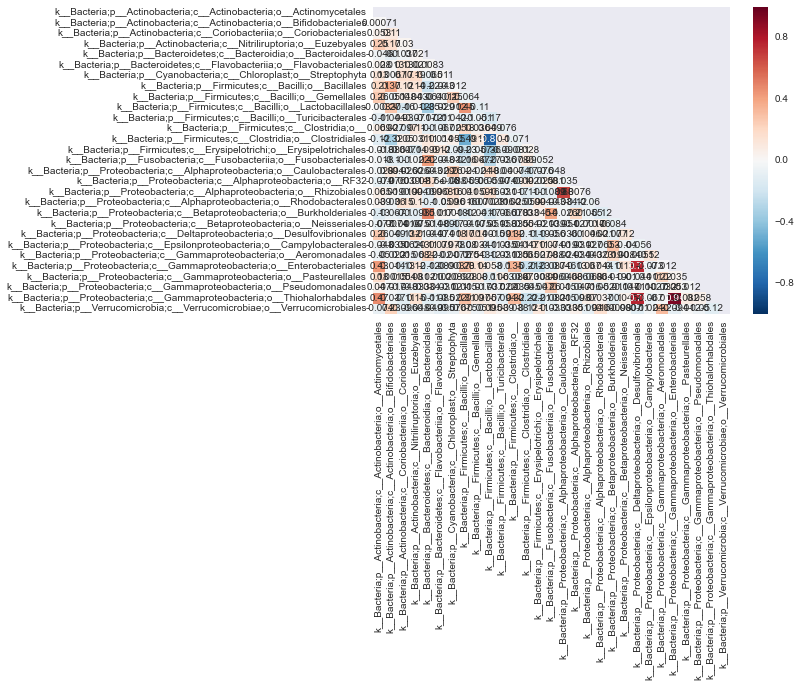

In [5]:
mf = load_mf('taxonomic_summaries/no-diarrhea/mapping-file-full.alpha_L3.txt')

# dataframe from the group significance table
gsdf = pd.read_csv('stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L4.tsv',
                   sep='\t')

# keep only the significant OTUs
bt = load_table('stats/group-significance/no-diarrhea/taxa-summaries-5pct/otu_table.15000.no-diarrhea.5pct_L4.biom')
bt.filter(gsdf.OTU.astype(str), axis='observation', inplace=True)
bt.norm()
df = exploding_panda(bt)

gsdf = gsdf[gsdf['Bonferroni_P'] < 0.05]

# Generate a mask for the upper triangle
mask = np.zeros_like(df.T.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure()
sns.heatmap(df[mf[mf.disease_stat == 'healthy'].index].T.corr(), mask=mask, annot=True)

plt.figure()
sns.heatmap(df[mf[mf.disease_stat != 'healthy'].index].T.corr(), mask=mask, annot=True)

plt.figure()
sns.heatmap(df.T.corr(), mask=mask, annot=True)

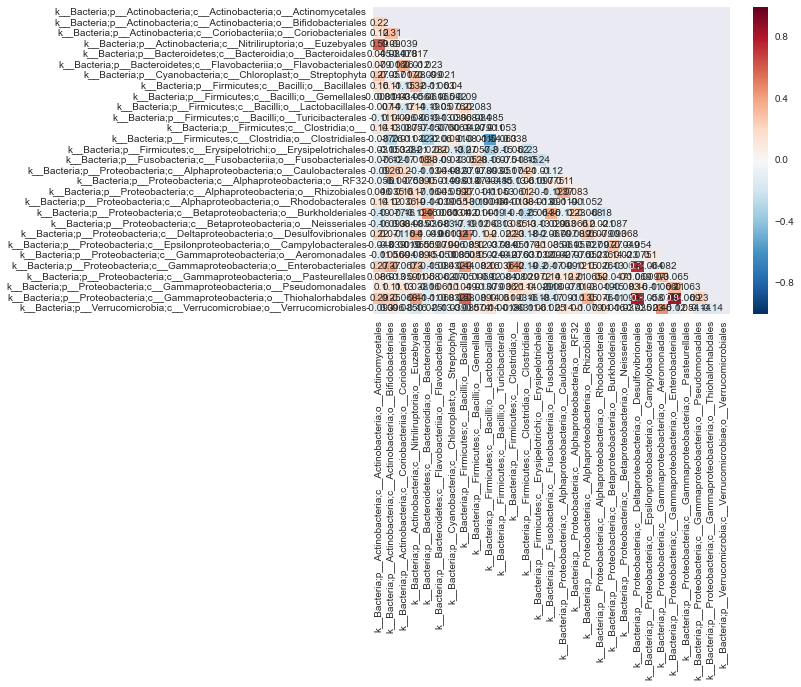

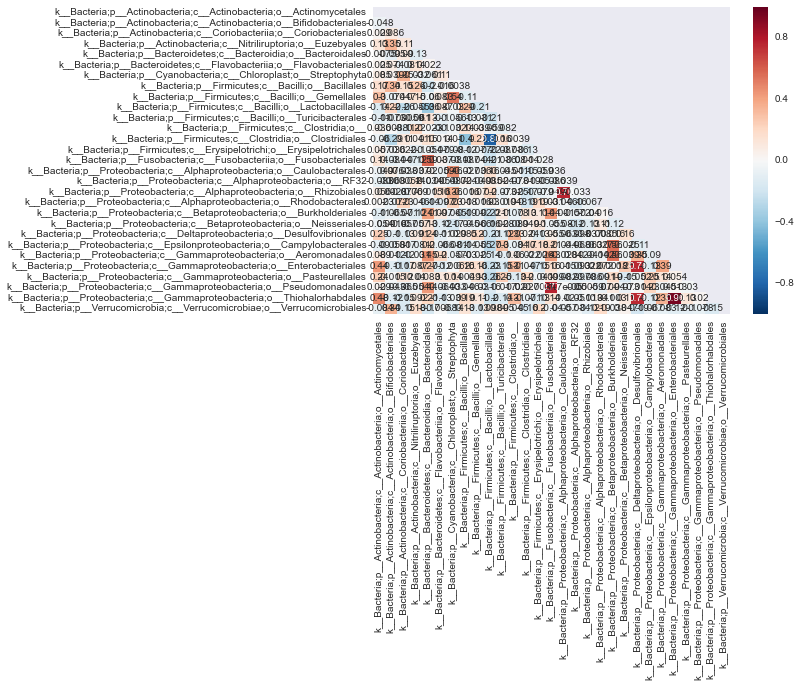

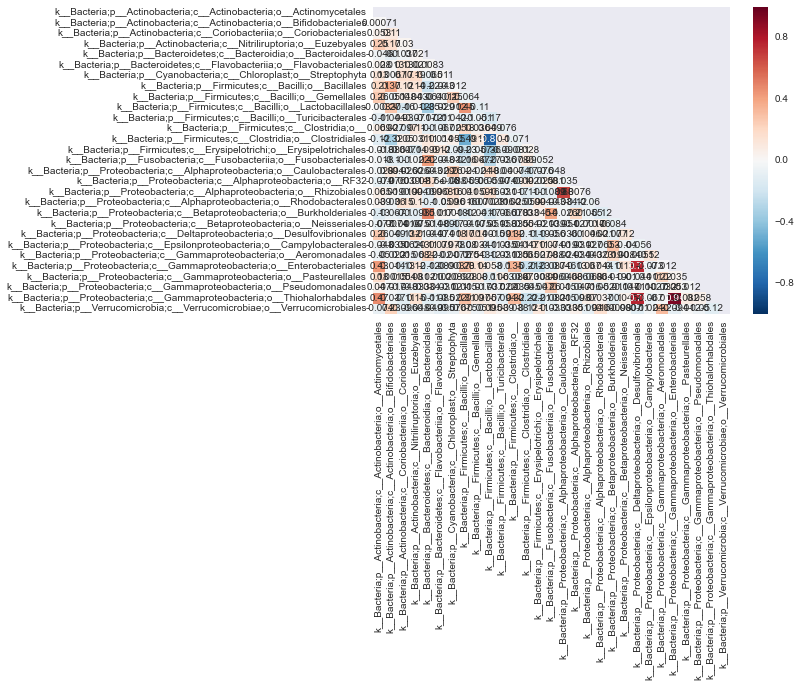

In [6]:
mf = load_mf('taxonomic_summaries/no-diarrhea/mapping-file-full.alpha_L3.txt')

# dataframe from the group significance table
gsdf = pd.read_csv('stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L3.tsv',
                   sep='\t')
gsdf = gsdf[gsdf['Bonferroni_P'] < 0.05]

# Generate a mask for the upper triangle
mask = np.zeros_like(df.T.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


healthy = ['betaproteobacteria', 'bacteroidia', 'fusobacteriia', 'epsilonproteobacteria', 'clostridia', 'coriobacteriia']
sick = ['actinobacteria', 'bacilli', 'gammaproteobacteria']

names = []
for h in healthy:
    names += [a for a in mf.columns if 'c__' + h in a.lower()]

for s in sick:
    names += [a for a in mf.columns if 'c__' + s in a.lower()]
    
for name in names:
    mf[name] = mf[name].astype(np.float)

In [8]:
gsdf

,OTU,Test-Statistic,P,FDR_P,Bonferroni_P,healthy_mean,IBD_mean
0,k__Bacteria;p__Bacteroidetes;c__Bacteroidia,53.480132,2.612213e-13,4.179541e-12,4.179541e-12,0.047248,0.006194
1,k__Bacteria;p__Firmicutes;c__Bacilli,50.385309,1.263365e-12,1.010692e-11,2.021383e-11,0.069179,0.371496
2,k__Bacteria;p__Fusobacteria;c__Fusobacteriia,41.730476,1.047632e-10,5.587370e-10,1.676211e-09,0.034371,0.008413
3,k__Bacteria;p__Firmicutes;c__Erysipelotrichi,35.651367,2.359822e-09,9.439288e-09,3.775715e-08,0.122612,0.056017
4,k__Bacteria;p__Firmicutes;c__Clostridia,33.664250,6.549333e-09,2.095787e-08,1.047893e-07,0.675744,0.451239
5,k__Bacteria;p__Proteobacteria;c__Gammaproteoba...,21.176509,4.188672e-06,1.116979e-05,6.701875e-05,0.015056,0.062592
6,k__Bacteria;p__Proteobacteria;c__Betaproteobac...,14.080454,1.751546e-04,4.003533e-04,2.802473e-03,0.001950,0.000476
7,k__Bacteria;p__Actinobacteria;c__Actinobacteria,11.172702,8.300962e-04,1.660192e-03,1.328154e-02,0.001274,0.007269
8,k__Bacteria;p__Proteobacteria;c__Epsilonproteo...,9.131116,2.512984e-03,4.467527e-03,4.020774e-02,0.000941,0.000111


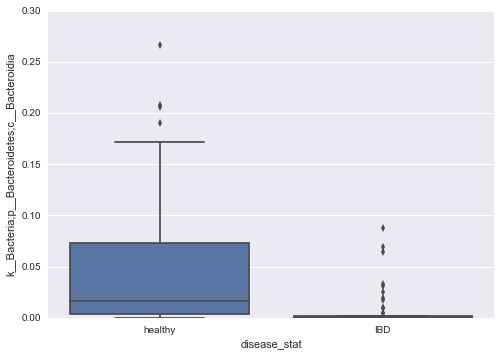

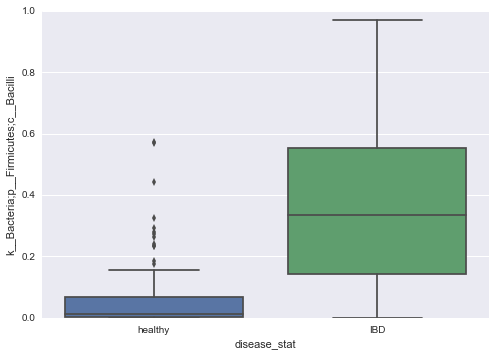

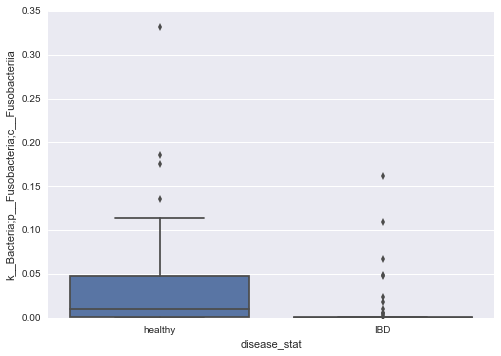

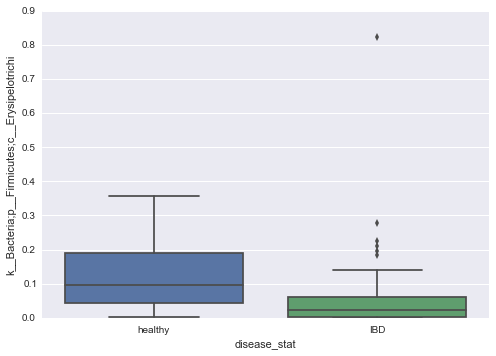

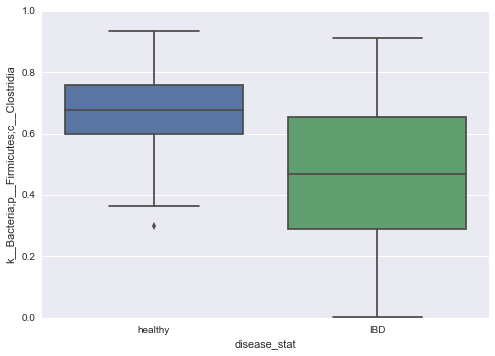

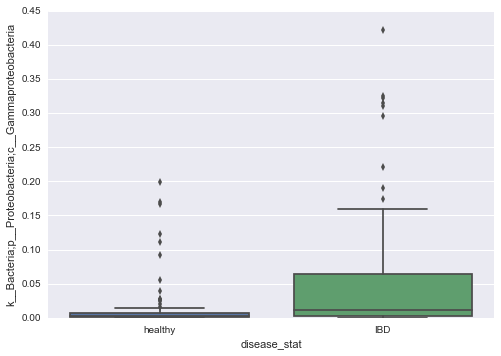

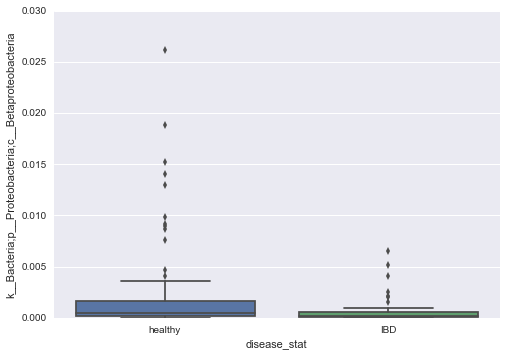

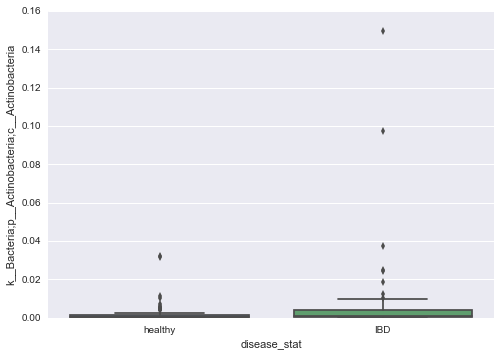

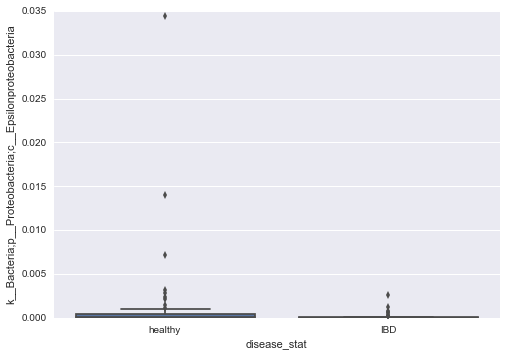

In [15]:
mf = load_mf('taxonomic_summaries/no-diarrhea/mapping-file-full.alpha_L4.txt')

for name in gsdf.OTU.tolist():
    mf[name] = mf[name].astype(np.float)

for name in gsdf.OTU.tolist():
    plt.figure()
    sns.boxplot(x='disease_stat', y=name, data=mf)

In [26]:
# dataframe from the group significance table
gsdf = pd.read_csv('stats/group-significance/no-diarrhea/kruskall-wallis-5pct-L5.tsv',
                   sep='\t')
gsdf = gsdf[gsdf['Bonferroni_P'] < 0.05]

def funk(row):
    if row['healthy_mean'] > row['IBD_mean']:
        return 'Healthy Enriched'
    elif row['healthy_mean'] < row['IBD_mean']:
        return 'Diseased Enriched'
    else:
        return 'WTF???'

gsdf['classification'] = gsdf.apply(funk, axis=1, reduce=True)

good = gsdf[gsdf.classification == 'Healthy Enriched'].OTU
bad = gsdf[gsdf.classification != 'Healthy Enriched'].OTU

In [8]:
good

0     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1     k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
2     k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...
3     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
4     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
8     k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
9     k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
11    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
14    k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...
15    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
19    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
20    k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...
22    k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
23    k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...
27    k__Bacteria;p__Proteobacteria;c__Betaproteobac...
29    k__Bacteria;p__Firmicutes;c__Bacilli;o__Turici...
35    k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
38    k__Bacteria;p__Firmicutes;c__Erysipelotric

In [9]:
bad

5     k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
6     k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
7     k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
10    k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
12    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
13    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
16    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
17    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
18    k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
21    k__Bacteria;p__Proteobacteria;c__Gammaproteoba...
24    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
25    k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
26    k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...
28    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
30    k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
31    k__Bacteria;p__Proteobacteria;c__Gammaproteoba...
32    k__Bacteria;p__Proteobacteria;c__Gammaproteoba...
33    k__Bacteria;p__Proteobacteria;c__Gammaprot

In [32]:
# mf = load_mf('taxonomic_summaries/no-diarrhea/mapping-file-full.alpha_L5.txt')
mf = load_mf('mapping-file-full.alpha.L6index.txt')

mf['Healthy'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)
mf['Sick'] = pd.Series(np.zeros_like(mf.index.values), mf.index, dtype=np.float)
for column_name in mf.columns:
    if any([True for p in good if p in column_name]):
        mf['Healthy'] += mf[column_name].astype(np.float)
    elif any([True for i in bad if i in column_name]):
        mf['Sick'] += mf[column_name].astype(np.float)
    else:
        continue

# calculating the dysbiosis index
mf['MD_Index'] = np.divide(mf['Sick'], mf['Healthy']).astype(np.float)
# drop any samples with undefined values
mf['MD_Index'].replace({0: np.nan}, inplace=True)

In [34]:
mf.PD_whole_tree_even_15000_alpha = pd.to_numeric(mf.PD_whole_tree_even_15000_alpha, errors=False)

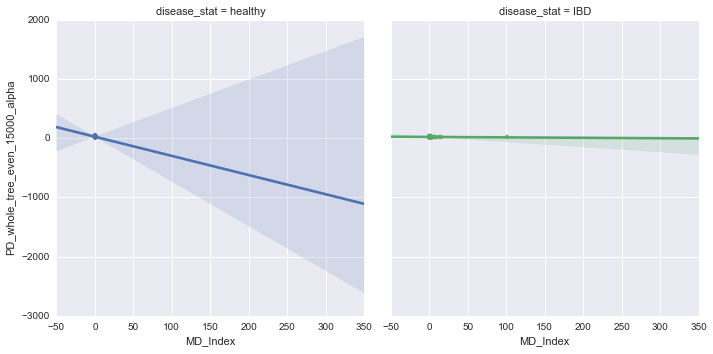

In [35]:
sns.set(style="darkgrid")
sns.lmplot('MD_Index', 'PD_whole_tree_even_15000_alpha', mf, hue='disease_stat', col='disease_stat')

In [ ]:
mf = load_mf('taxonomic_summaries/no-diarrhea/mapping-file-full.alpha_L4.txt')

for name in gsdf.OTU.tolist():
    mf[name] = mf[name].astype(np.float)

for name in gsdf.OTU.tolist():
    plt.figure()
    sns.boxplot(x='disease_stat', y=name, data=mf)